# Import libraries

In [1]:
import tensorflow as tf 
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import plotly.graph_objs as go
from plotly.offline import iplot
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import Model, Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

2023-04-12 11:31:51.804154: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 11:31:52.331217: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/airi/anaconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Transfer Learning using ResNet-50, VGG-19, MobileNetV3 and InceptionV3 CNN Models
#### Load dataset

In [2]:
data_dir = "Plant_leaf_diseases_dataset_with_augmentation/"  ## Dataset directory
img_width, img_height = 224, 224 
channels = 3
batch_size = 64 

### Data preprocessing

#### Unbalanced data

In [12]:
dict_prev = {}
# Set the path to the parent folder
parent_folder_path = data_dir

# Iterate over the subfolders in the parent folder
for subfolder_name in os.listdir(parent_folder_path):
    
    # Create the full path to the subfolder
    subfolder_path = os.path.join(parent_folder_path, subfolder_name)
    # Check if the subfolder is actually a folder
    if os.path.isdir(subfolder_path):
        
        # Count the number of files in the subfolder
        num_files = len(os.listdir(subfolder_path))
        
        # Add the subfolder name and number of files to the dictionary
        dict_prev[subfolder_name] = num_files

In [ ]:
df = pd.DataFrame({'Labels': list(dict_prev.keys()), 'Counts': list(dict_prev.values())})
fig = go.Figure([go.Bar(x=df['Labels'], y=df['Counts'])])
iplot(fig)

# 1.Orange___Haunglongbing_(Citrus_greening)
# 2.Soybean___healthy
# 3.Tomato___Tomato_Yellow_Leaf_Curl_Virus
#Since the number of images in the above three classes is more than the average number of images,
#we will take 2000 images in each class and delete the rest

####  Balanced data

In [15]:
dict_next = {}
# Set the path to the parent folder
parent_folder_path = data_dir

# Iterate over the subfolders in the parent folder
for subfolder_name in os.listdir(parent_folder_path):
    
    # Create the full path to the subfolder
    subfolder_path = os.path.join(parent_folder_path, subfolder_name)
    # Check if the subfolder is actually a folder
    if os.path.isdir(subfolder_path):
        
        # Count the number of files in the subfolder
        num_files = len(os.listdir(subfolder_path))
        
        # Add the subfolder name and number of files to the dictionary
        dict_next[subfolder_name] = num_files

In [67]:
df = pd.DataFrame({'Labels': list(dict_next.keys()), 'Counts': list(dict_next.values())})
fig = go.Figure([go.Bar(x=df['Labels'], y=df['Counts'])])
iplot(fig)

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 51532 files belonging to 39 classes.
Using 41226 files for training.


2023-04-12 11:32:02.618677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-12 11:32:02.618880: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-12 11:32:02.644451: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)   

Found 51532 files belonging to 39 classes.
Using 10306 files for validation.


In [5]:
class_names = train_ds.class_names ### classes' name

In [168]:
# class_names

#### Visualization

2023-04-11 15:42:45.961751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [41226]
	 [[{{node Placeholder/_4}}]]
2023-04-11 15:42:45.961980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [41226]
	 [[{{node Placeholder/_4}}]]


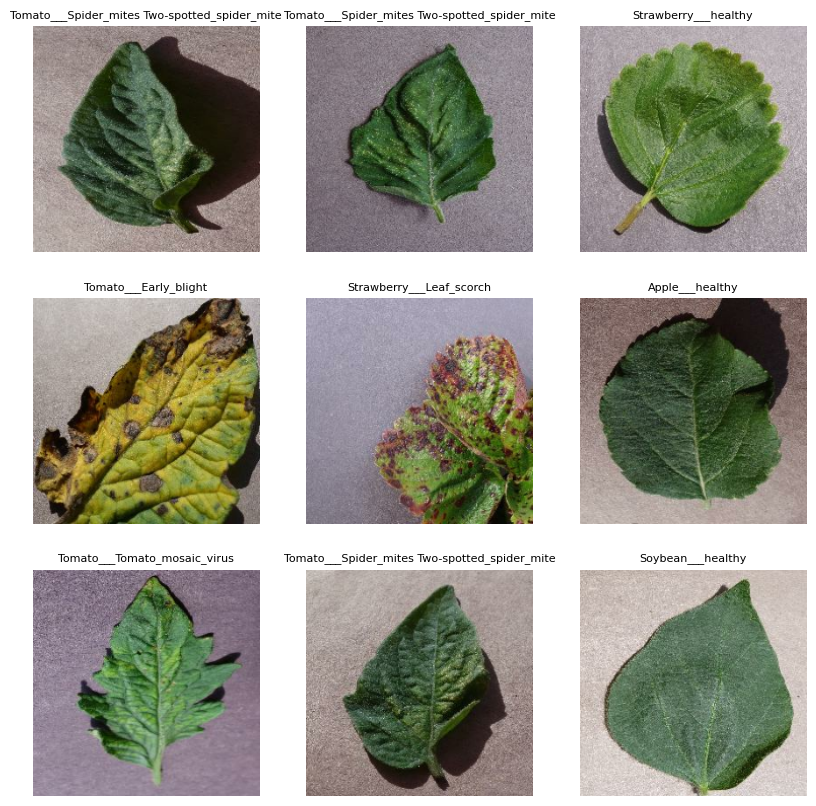

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]], fontsize = 8)
        plt.axis("off")

In [6]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [7]:
### normalized_train_ds
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.87982714


2023-04-12 11:32:11.393361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [41226]
	 [[{{node Placeholder/_4}}]]
2023-04-12 11:32:11.393577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [41226]
	 [[{{node Placeholder/_4}}]]


In [8]:
for img, lb in normalized_train_ds:
    image = img.shape
    break 
print(image)

(64, 224, 224, 3)


In [9]:
### normalized_tes_ds
normalized_test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_test_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.064204834 0.8492579


2023-04-12 11:32:18.384159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [10306]
	 [[{{node Placeholder/_4}}]]
2023-04-12 11:32:18.384372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [10306]
	 [[{{node Placeholder/_4}}]]


## 1.ResNet-50
#### 1.1 To build the model via ResNet-50

In [28]:
resnet50 = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    input_shape= (img_width, img_height, channels),
    weights='imagenet'
)
# resnet50.summary()

In [29]:
model = Sequential()
for layer in resnet50.layers:
    layer.trainable = False #o turn off VGG19's trainable weights
model.add(resnet50)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dense(39, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_10 (Dense)            (None, 1024)              102761472 
                                                                 
 dense_11 (Dense)            (None, 256)               262400    
                                                                 
 dense_12 (Dense)            (None, 39)                10023     
                                                                 
Total params: 126,621,607
Trainable params: 103,033,895
Non-trainable params: 23,587,712
_________________________________________________________________


In [30]:
# To select the optimizer ans the loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [31]:
# Compile the model
model.compile(optimizer=optimizer, loss=loss_object, metrics=['accuracy'])

#### 1.2 Callbacks

In [32]:
checkpoint = ModelCheckpoint(
    'model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)
csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)
reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)
callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [33]:
### To fit the model
history = model.fit(
    normalized_train_ds, 
    epochs = 10,
    validation_data = normalized_test_ds, 
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/10
644/645 [============================>.] - ETA: 0s - loss: 3.3869 - accuracy: 0.2176
Epoch 1: val_loss improved from inf to 2.39458, saving model to model.h5
645/645 [==============================] - 98s 149ms/step - loss: 3.3866 - accuracy: 0.2176 - val_loss: 2.3946 - val_accuracy: 0.2970 - lr: 0.0010
Epoch 2/10
644/645 [============================>.] - ETA: 0s - loss: 1.9434 - accuracy: 0.4234
Epoch 2: val_loss improved from 2.39458 to 1.67833, saving model to model.h5
645/645 [==============================] - 96s 148ms/step - loss: 1.9435 - accuracy: 0.4233 - val_loss: 1.6783 - val_accuracy: 0.4984 - lr: 0.0010
Epoch 3/10
644/645 [============================>.] - ETA: 0s - loss: 1.6808 - accuracy: 0.4907
Epoch 3: val_loss did not improve from 1.67833
645/645 [==============================] - 94s 145ms/step - loss: 1.6809 - accuracy: 0.4908 - val_loss: 1.7529 - val_accuracy: 0.4632 - lr: 0.0010
Epoch 4/10
644/645 [============================>.] - ETA: 0s - loss: 1.53

In [34]:
model.evaluate(normalized_test_ds)

162/162 [==============================] - 17s 107ms/step - loss: 1.2380 - accuracy: 0.6167


[1.2380130290985107, 0.6167281270027161]

## 2.VGG-19
#### 2.1 To build the model via VGG-19

In [42]:
vgg19 = tf.keras.applications.vgg19.VGG19(
    include_top = False, 
    input_shape = (img_width, img_height, channels), 
    weights = 'imagenet')
# vgg19.summary()  ### To show the model's architecture

In [43]:
model = Sequential()
for layer in vgg19.layers:
    layer.trainable = False #o turn off VGG19's trainable weights
model.add(vgg19)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dense(39, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_16 (Dense)            (None, 1024)              25691136  
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_17 (Dense)            (None, 256)               262400    
                                                                 
 dense_18 (Dense)            (None, 39)                10023     
                                                                 
Total params: 45,987,943
Trainable params: 25,963,559


In [44]:
# To select the optimizer ans the loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [45]:
# Compile the model
model.compile(optimizer=optimizer, loss=loss_object, metrics=['accuracy'])

#### 2.2 Callbacks

In [46]:
checkpoint = ModelCheckpoint(
    'model_vgg19.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)
csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)
reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)
callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [47]:
### To fit the model
history = model.fit(
    normalized_train_ds, 
    epochs = 10,
    validation_data = normalized_test_ds, 
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/10
644/645 [============================>.] - ETA: 0s - loss: 1.0708 - accuracy: 0.7008
Epoch 1: val_loss improved from inf to 0.48626, saving model to model_vgg19.h5
645/645 [==============================] - 169s 260ms/step - loss: 1.0709 - accuracy: 0.7007 - val_loss: 0.4863 - val_accuracy: 0.8402 - lr: 0.0010
Epoch 2/10
644/645 [============================>.] - ETA: 0s - loss: 0.4704 - accuracy: 0.8453
Epoch 2: val_loss improved from 0.48626 to 0.34861, saving model to model_vgg19.h5
645/645 [==============================] - 168s 260ms/step - loss: 0.4704 - accuracy: 0.8453 - val_loss: 0.3486 - val_accuracy: 0.8813 - lr: 0.0010
Epoch 3/10
644/645 [============================>.] - ETA: 0s - loss: 0.3819 - accuracy: 0.8725
Epoch 3: val_loss improved from 0.34861 to 0.30789, saving model to model_vgg19.h5
645/645 [==============================] - 168s 260ms/step - loss: 0.3819 - accuracy: 0.8725 - val_loss: 0.3079 - val_accuracy: 0.8955 - lr: 0.0010
Epoch 4/10
644/645 [===

In [48]:
model.evaluate(normalized_test_ds)

162/162 [==============================] - 33s 203ms/step - loss: 0.2718 - accuracy: 0.9138


[0.2718251645565033, 0.9138365983963013]

## 3.MobileNetV3
#### 3.1 To build the model via MobileNetV3

In [10]:
mobilenet_v3 = tf.keras.applications.MobileNetV3Large(
    include_top=False,
    input_shape=(img_width, img_height, channels),
    weights='imagenet'
)
# mobilenet_v3.summary()

In [11]:
model = Sequential()
for layer in mobilenet_v3.layers:
    layer.trainable = False #o turn off VGG19's trainable weights
model.add(mobilenet_v3)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dense(39, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 47040)             0         
                                                                 
 dense (Dense)               (None, 1024)              48169984  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dense_2 (Dense)             (None, 39)                10023     
                                                        

In [14]:
# To select the optimizer ans the loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

#### 3.2 Callbacks

In [15]:
checkpoint = ModelCheckpoint(
    'model_mobilenet_v3.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)
csvlogger = CSVLogger(
    filename= "training_mobilenet_v3_csv.log",
    separator = ",",
    append = False
)
reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)
callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [16]:
# Compile the model
model.compile(optimizer=optimizer, loss=loss_object, metrics=['accuracy'])

In [17]:
### To fit the model
history = model.fit(
    normalized_train_ds, 
    epochs = 10,
    validation_data = normalized_test_ds, 
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/10


/home/airi/anaconda3/envs/tf/lib/python3.9/site-packages/keras/backend.py:5612: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?

2023-04-12 11:35:55.717095: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-12 11:35:56.166986: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2023-04-12 11:35:56.169320: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-04-12 11:35:56.169348: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-04-12 11:35:56.169443: W tensorf

645/645 [==============================] - ETA: 0s - loss: 3.2516 - accuracy: 0.1214
Epoch 1: val_loss improved from inf to 2.77262, saving model to model_mobilenet_v3.h5
645/645 [==============================] - 49s 69ms/step - loss: 3.2516 - accuracy: 0.1214 - val_loss: 2.7726 - val_accuracy: 0.2296 - lr: 0.0010
Epoch 2/10
644/645 [============================>.] - ETA: 0s - loss: 2.8363 - accuracy: 0.1941
Epoch 2: val_loss improved from 2.77262 to 2.42201, saving model to model_mobilenet_v3.h5
645/645 [==============================] - 44s 68ms/step - loss: 2.8361 - accuracy: 0.1942 - val_loss: 2.4220 - val_accuracy: 0.2976 - lr: 0.0010
Epoch 3/10
644/645 [============================>.] - ETA: 0s - loss: 2.6273 - accuracy: 0.2428
Epoch 3: val_loss did not improve from 2.42201
645/645 [==============================] - 43s 67ms/step - loss: 2.6273 - accuracy: 0.2428 - val_loss: 2.4517 - val_accuracy: 0.3083 - lr: 0.0010
Epoch 4/10
644/645 [============================>.] - ETA: 0s 

In [18]:
model.evaluate(normalized_test_ds)

162/162 [==============================] - 8s 50ms/step - loss: 2.0756 - accuracy: 0.3917


[2.075559377670288, 0.39171355962753296]

## 4.InceptionV3
#### 4.1 To build the model via InceptionV3

In [19]:
inception_v3 = tf.keras.applications.InceptionV3(
    include_top=False,
    input_shape=(img_width, img_height, channels),
    weights='imagenet'
)
# inception_v3.summary()

In [20]:
model = Sequential()
for layer in inception_v3.layers:
    layer.trainable = False #o turn off VGG19's trainable weights
model.add(inception_v3)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dense(39, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_3 (Dense)             (None, 1024)              52429824  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               262400    
                                                                 
 dense_5 (Dense)             (None, 39)                10023     
                                                                 
Total params: 74,505,031
Trainable params: 52,702,247


In [21]:
# To select the optimizer ans the loss
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

#### 4.2 Callbacks

In [22]:
checkpoint = ModelCheckpoint(
    'model_inception_v3.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)
csvlogger = CSVLogger(
    filename= "training_inception_v3_csv.log",
    separator = ",",
    append = False
)
reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)
callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [23]:
# Compile the model
model.compile(optimizer=optimizer, loss=loss_object, metrics=['accuracy'])

In [24]:
### To fit the model
history = model.fit(
    normalized_train_ds, 
    epochs = 10,
    validation_data = normalized_test_ds, 
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/10


/home/airi/anaconda3/envs/tf/lib/python3.9/site-packages/keras/backend.py:5612: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



  2/645 [..............................] - ETA: 48s - loss: 18.5475 - accuracy: 0.0312 

2023-04-12 11:44:38.421161: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



645/645 [==============================] - ETA: 0s - loss: 1.9366 - accuracy: 0.6572
Epoch 1: val_loss improved from inf to 0.52516, saving model to model_inception_v3.h5
645/645 [==============================] - 70s 101ms/step - loss: 1.9366 - accuracy: 0.6572 - val_loss: 0.5252 - val_accuracy: 0.8321 - lr: 0.0010
Epoch 2/10
644/645 [============================>.] - ETA: 0s - loss: 0.5891 - accuracy: 0.8152
Epoch 2: val_loss improved from 0.52516 to 0.41022, saving model to model_inception_v3.h5
645/645 [==============================] - 63s 98ms/step - loss: 0.5891 - accuracy: 0.8152 - val_loss: 0.4102 - val_accuracy: 0.8713 - lr: 0.0010
Epoch 3/10
644/645 [============================>.] - ETA: 0s - loss: 0.4749 - accuracy: 0.8497
Epoch 3: val_loss improved from 0.41022 to 0.37512, saving model to model_inception_v3.h5
645/645 [==============================] - 64s 99ms/step - loss: 0.4748 - accuracy: 0.8498 - val_loss: 0.3751 - val_accuracy: 0.8818 - lr: 0.0010
Epoch 4/10
644/645

In [25]:
model.evaluate(normalized_test_ds)

162/162 [==============================] - 12s 73ms/step - loss: 0.3429 - accuracy: 0.9067


[0.3429422676563263, 0.9066563248634338]

# To build architecture from scratch
#### Architecture

In [33]:
# Define your model
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', padding = 'same')
        self.conv2 = Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding = 'same')
        self.conv3 = Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding = 'same')
        self.conv4 = Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding = 'same')
        self.pooling = MaxPooling2D(pool_size = (2, 2), strides = 2)
        self.drop = Dropout(rate = 0.25)
        self.drop1 = Dropout(rate = 0.5)
        self.flatten = Flatten()
#         self.d1 = Dense(2048, activation='relu')
#         self.d2 = Dense(512, activation='relu')
        self.d3 = Dense(128, activation='relu')
        self.dense_output = Dense(39, activation = 'softmax')  

    def call(self, x):
        conv1_1 = self.conv1(x)
        pool = self.pooling(conv1_1)
        conv2_2 = self.conv2(pool)
        pool = self.pooling(conv2_2)
        conv3_3 = self.conv3(pool)
        pool = self.pooling(conv3_3)
        conv4_4 = self.conv4(pool)
        pool = self.pooling(conv4_4)
        droping = self.drop(pool)
        flatten_1  = self.flatten(droping)
        
        hidden_1 = self.d3(flatten_1)
        droping1 = self.drop1(hidden_1)
        
#         hidden_2 = self.d2(droping)
#         
#         hidden_3 = self.d3(hidden_2)
        
        return self.dense_output(droping1)

# Create an instance of the model
model = MyModel()

In [34]:
# Define your loss function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Define your optimizer
optimizer = tf.keras.optimizers.Adam()

In [35]:
# Define your metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [36]:
# Define the checkpoint directory and file name
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# Define the callback for saving the model
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)


In [37]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [38]:
@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [39]:
EPOCHS = 10

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for images, labels in normalized_train_ds:
        train_step(images, labels)

    for test_images, test_labels in normalized_test_ds:
        test_step(test_images, test_labels)
        
    # Save the model after each epoch
    model.save_weights(checkpoint_prefix.format(epoch=epoch)) 
    
    print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
    )

2023-04-12 12:09:21.731469: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmy_model_1/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-04-12 12:10:11.396671: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmy_model_1/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 1, Loss: 2.1447134017944336, Accuracy: 39.86076736450195, Test Loss: 1.0766417980194092, Test Accuracy: 68.05744171142578
Epoch 2, Loss: 1.152511477470398, Accuracy: 65.17974090576172, Test Loss: 0.5889909267425537, Test Accuracy: 82.73820495605469
Epoch 3, Loss: 0.8417851328849792, Accuracy: 73.72046661376953, Test Loss: 0.43927571177482605, Test Accuracy: 86.42538452148438
Epoch 4, Loss: 0.6642081141471863, Accuracy: 79.01567077636719, Test Loss: 0.37274616956710815, Test Accuracy: 88.19134521484375
Epoch 5, Loss: 0.5601218342781067, Accuracy: 82.15931701660156, Test Loss: 0.27459409832954407, Test Accuracy: 91.49039459228516
Epoch 6, Loss: 0.48874393105506897, Accuracy: 84.53160858154297, Test Loss: 0.2397346943616867, Test Accuracy: 92.72268676757812
Epoch 7, Loss: 0.4255015254020691, Accuracy: 86.41149139404297, Test Loss: 0.23266460001468658, Test Accuracy: 93.00407409667969
Epoch 8, Loss: 0.37304797768592834, Accuracy: 87.78926086425781, Test Loss: 0.20729678869247437, Tes

In [40]:
model.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          multiple                  896       
                                                                 
 conv2d_99 (Conv2D)          multiple                  18496     
                                                                 
 conv2d_100 (Conv2D)         multiple                  36928     
                                                                 
 conv2d_101 (Conv2D)         multiple                  36928     
                                                                 
 max_pooling2d_5 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                        

In [41]:
# save the model in SavedModel format as tf
model.save('scratch', save_format='tf')

2023-04-12 12:20:39.961473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,14,14,64]
	 [[{{node inputs}}]]
2023-04-12 12:20:40.169278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-12 12:20:40.353676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,14,14,64]
	 [[{{node inputs}}]]
2023-0

INFO:tensorflow:Assets written to: scratch/assets


INFO:tensorflow:Assets written to: scratch/assets


In [42]:
!pip freeze

absl-py==1.4.0
array-record==0.2.0
asttokens==2.2.1
astunparse==1.6.3
attrs==22.2.0
backcall==0.2.0
cachetools==5.3.0
certifi==2022.12.7
charset-normalizer==3.1.0
click==8.1.3
comm==0.1.3
contourpy==1.0.7
cycler==0.11.0
debugpy==1.6.6
decorator==5.1.1
dm-tree==0.1.8
etils==1.2.0
executing==1.2.0
fastjsonschema==2.16.3
flatbuffers==23.3.3
fonttools==4.39.3
gast==0.4.0
google-auth==2.17.1
google-auth-oauthlib==1.0.0
google-pasta==0.2.0
googleapis-common-protos==1.59.0
grpcio==1.53.0
h5py==3.8.0
idna==3.4
importlib-metadata==6.1.0
importlib-resources==5.12.0
ipykernel==6.22.0
ipython==8.12.0
jax==0.4.8
jedi==0.18.2
jsonschema==4.17.3
jupyter_client==8.1.0
jupyter_core==5.3.0
keras==2.12.0
kiwisolver==1.4.4
libclang==16.0.0
Markdown==3.4.3
MarkupSafe==2.1.2
matplotlib==3.7.1
matplotlib-inline==0.1.6
ml-dtypes==0.0.4
nbformat==5.8.0
nest-asyncio==1.5.6
numpy==1.23.5
nvidia-cublas-cu11==11.11.3.6
nvidia-cudnn-cu11==8.6.0.163
oauthlib==3.2.2
opt-einsum==3.3.0
packaging==23.0
pandas==2.0.0
par